# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import warnings 
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy import *
from scipy.sparse import *
from scipy.stats import uniform
from prettytable import PrettyTable

C:\Anaconda\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english')) #set of stopwords
words_to_keep = set(('not'))
stop -= words_to_keep

sno = nltk.stem.SnowballStemmer('english')
def cleanhtml(sentence): #function to clean any HTML Tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean any word of punctuation or special character
    cleaned = re.sub(r'[?|!|\'|"|#]',r'', sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ', cleaned)
    return cleaned

In [15]:
#code for implementing step by step check mentioned in preprocessing phase
#runtime wiil be high due to 500k sentences
i = 0
str1 = ' '
final_string = []
all_positive_words = []
all_negative_words = []
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive':
                        all_positive_words.append(s)
                    if (final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue
    str1 = b" ".join(filtered_sentence)
    final_string.append(str1)
    i+=1

In [16]:
final['cleanedText']=final_string #Adding a column of Cleanedtext which displays data after preprocesing.
final['cleanedText']=final['cleanedText'].str.decode("utf-8")
print('shape of final', final.shape)
final.head()

shape of final (87773, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleanedText
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infest fruitfli liter everywher fli around kit...
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...,worst product gotten long time would rate star...
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...,wish read review make purchas basic cardsotck ...


### Time Based Splitting For As AFR is Time series Data

In [17]:
#sorting data according to time in ascending oreder for time based splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
x = time_sorted_data['cleanedText'].values
y = time_sorted_data['Score']
#SPlit the dataset into Train and Test
X_train,X_test,Y_train,Y_test=train_test_split(x, y, test_size=0.3, random_state=0)

In [18]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [19]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [21]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [22]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [23]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [24]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [25]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [26]:
# Combining all the above stundents 
from tqdm import tqdm
from bs4 import BeautifulSoup
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [01:02<00:00, 1398.93it/s]


In [29]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [30]:
## Similartly you can do preprocessing for review summary also.
from tqdm import tqdm
preprocessed_summaries = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summaries.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:42<00:00, 2072.37it/s]


# [4] Featurization

## [4.1] BAG OF WORDS

In [120]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


## [4.2] Bi-Grams and n-Grams.

In [121]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [122]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able brew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 51709)
the number of unique words including both unigrams and bigrams  51709


## [4.4] Word2Vec

In [123]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [124]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.833054780960083), ('fantastic', 0.8282230496406555), ('terrific', 0.8178467154502869), ('good', 0.8172284364700317), ('excellent', 0.8095447421073914), ('perfect', 0.7762563228607178), ('wonderful', 0.7662094831466675), ('amazing', 0.7346127033233643), ('nice', 0.7282907366752625), ('fabulous', 0.7072104215621948)]
[('greatest', 0.7993786334991455), ('best', 0.7487739324569702), ('tastiest', 0.7091807126998901), ('nastiest', 0.6944457292556763), ('nicest', 0.6583582758903503), ('disgusting', 0.6164989471435547), ('freshest', 0.6153883337974548), ('smoothest', 0.6011213660240173), ('hottest', 0.6007328033447266), ('experienced', 0.5956722497940063)]


In [125]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17386
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'squishing', 'buggers', 'success', 'rate']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [34]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 87773/87773 [05:42<00:00, 256.37it/s]


87773
50


#### [4.4.1.2] TFIDF weighted W2v

In [126]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [127]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [1:19:43<00:00, 14.99it/s]


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [28]:
#Bow
count_vect = CountVectorizer(min_df =50)
X_train_vec = count_vect.fit_transform(X_train)
X_test_vec = count_vect.transform(X_test)
print("the type of count vectorizer ",type(X_train_vec))
print("the shape of out text BOW vectorizer ",X_train_vec.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_vec.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (61441, 3062)
the number of unique words including both unigrams and bigrams  3062


In [29]:
#Standardizing
sc = StandardScaler(with_mean=False)
X_train_vec_standardized = sc.fit_transform(X_train_vec)
X_test_vec_standardized = sc.transform(X_test_vec)

#### L2 Reguralization

In [30]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#using GridSearchCv
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring='accuracy', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n", model.best_estimator_)
print("Accuracy of model : ", model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The Optimal value Of C(1/lambda) is : ", optimal_C)

#Testing Logistic Regression with Optimal value of C:(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized, Y_train)
predictions = lr.predict(X_test_vec_standardized)

#varibles will be used at conclusion part
bow_l1_grid_C = optimal_C
bow_l1_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
bow_l1_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of model :  0.910147349233
The Optimal value Of C(1/lambda) is :  0.01


In [37]:
#Evaluate Accuracy
acc = accuracy_score(Y_test, predictions)* 100
print('\nTest Accuracy Of Classifier C = %.3f is %f%%' % (optimal_C, acc))

#Evaluate Precision
acc = precision_score(Y_test, predictions)
print('\nTest Precsion Of Classifier C = %.3f is %f' % (optimal_C, acc))

#Evaluate Recall
acc = recall_score(Y_test, predictions)
print('\nTest recall  Of Classifier C = %.3f is %f' % (optimal_C, acc))

#Evaluate F1-score
acc = f1_score(Y_test, predictions)
print('\nTest F1-score  Of Classifier C = %.3f is %f' % (optimal_C, acc))


Test Accuracy Of Classifier C = 0.010 is 91.208749%

Test Precsion Of Classifier C = 0.010 is 0.934074

Test recall  Of Classifier C = 0.010 is 0.963538

Test F1-score  Of Classifier C = 0.010 is 0.948577


Train Confusion Matrix
[[ 5688  4259]
 [  881 50613]]
Test Confusion Matrix
[[ 2322  1912]
 [  477 21621]]


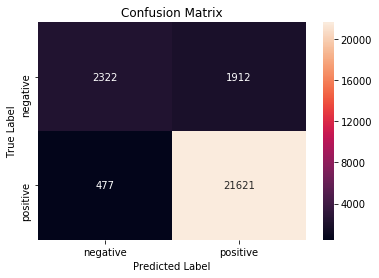

In [82]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)))
print("Test Confusion Matrix")
print(confusion_matrix(Y_test, lr.predict(X_test_vec_standardized)))
cm_test=confusion_matrix(Y_test, lr.predict(X_test_vec_standardized))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observation:
* By using GridSearchCV got an optimal C =0.01 with an acc 0.91% by L2 reg.

#### GridSearch CV Implementation

In [45]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#using GridSearchCv
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring='accuracy', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n", model.best_estimator_)
print("Accuracy of model : ", model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The Optimal value Of C(1/lambda) is : ", optimal_C)

#Testing Logistic Regression with Optimal value of C:(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized, Y_train)
predictions = lr.predict(X_test_vec_standardized)

#varibles will be used at conclusion part
bow_l1_grid_C = optimal_C
bow_l1_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
bow_l1_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of model :  0.909273887285
The Optimal value Of C(1/lambda) is :  0.01


In [46]:
#Evaluate Accuracy
acc = accuracy_score(Y_test, predictions)* 100
print('\nTest Accuracy Of Classifier C = %f is %f%%' % (optimal_C, acc))

#Evaluate Precision
acc = precision_score(Y_test, predictions)
print('\nTest Precsion Of Classifier C = %f is %f%%' % (optimal_C, acc))

#Evaluate Recall
acc = recall_score(Y_test, predictions)
print('\nTest recall  Of Classifier C = %f is %f%%' % (optimal_C, acc))

#Evaluate F1-score
acc = f1_score(Y_test, predictions)
print('\nTest F1-score  Of Classifier C = %f is %f%%' % (optimal_C, acc))



Test Accuracy Of Classifier C = 0.010000 is 90.931186%

Test Precsion Of Classifier C = 0.010000 is 0.918791%

Test recall  Of Classifier C = 0.010000 is 0.978414%

Test F1-score  Of Classifier C = 0.010000 is 0.947666%


Train Confusion Matrix
[[ 4845  2102]
 [  291 35770]]
Test Confusion Matrix
[[ 2260  1968]
 [  475 21629]]


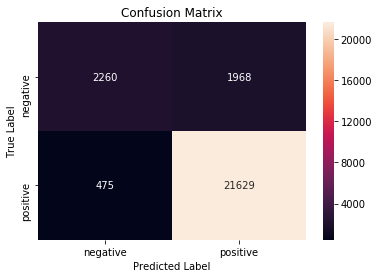

In [28]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(y_train, lr.predict(X_train)))
print("Test Confusion Matrix")
print(confusion_matrix(y_test, lr.predict(X_test)))
cm_test=confusion_matrix(y_test, lr.predict(X_test))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observation:
* by using gridSearchCV got an optimal C =0.01, and acc 0.90% with L1 reg.

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [31]:
# Please write all the code with proper documentation
lr=LogisticRegression(penalty='l1', C=optimal_C)
lr.fit(X_train_vec_standardized, Y_train)
weight=lr.coef_
print('No Of Non Zero Elemnts in Weight Vector ', np.count_nonzero(weight))

No Of Non Zero Elemnts in Weight Vector  1031


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

Train Confusion Matrix
[[ 6299   648]
 [   78 35983]]
Test Confusion Matrix
[[ 2432  1796]
 [  622 21482]]


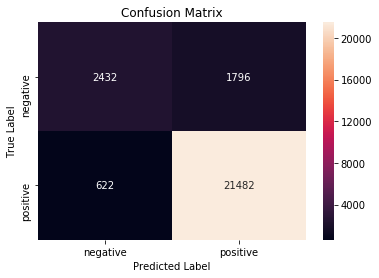

In [35]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(y_train, lr.predict(X_train)))
print("Test Confusion Matrix")
print(confusion_matrix(y_test, lr.predict(X_test)))
cm_test=confusion_matrix(y_test, lr.predict(X_test))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [32]:
# Please write all the code with proper documentation
#for checking multicollinearity we add e(small value) to train vector
W_before=lr.coef_

X_e=X_train_vec_standardized

X_e.data=X_e.data+np.random.normal(loc=0,scale=0.0001,size=X_e.data.shape)

X_e.shape


(61441, 3062)

In [56]:
#pertubation Testing
index = []

lr_e=LogisticRegression(penalty='l2',C=optimal_C)
lr_e.fit(X_train_vec_standardized, Y_train)
w=lr_e.coef_+0.0000001
#print(np.shape(w))
print("w:", w)


X_train_vec_standardized.data += 0.001
lr_e.fit(X_train_vec_standardized, Y_train)
w_1=lr_e.coef_+0.0000001
#print(np.shape(w_1))
print("w_1: ",w_1)

per_array = np.abs((w-w_1)/w)*100
print("per_array: ", per_array)

w: [[-0.02975546  0.04099509  0.03738226 ...,  0.00627243  0.01757338
   0.03032131]]
w_1:  [[-0.02975719  0.04098736  0.03736588 ...,  0.00627341  0.01757719
   0.03031503]]
per_array:  [[ 0.00581971  0.01884653  0.04381662 ...,  0.01561277  0.0216365
   0.02070938]]


In [57]:
#percentiles from 1-100
for i in range(0,101,10):
    Weights = np.percentile(per_array, i)
    print("Weights = ",Weights)
print("****************************")

Weights =  2.49854481583e-06
Weights =  0.0016822818262
Weights =  0.00350169041836
Weights =  0.0054459530875
Weights =  0.00769668690259
Weights =  0.0100830093865
Weights =  0.0132947518548
Weights =  0.0178449876066
Weights =  0.0257688076656
Weights =  0.0501968397804
Weights =  55.6837437173
****************************


In [58]:
#percentiles from 90-100Th
for i in range(90,101,1):
    Weights = np.percentile(per_array, i)
    print("Weights = ",Weights)
print("****************************")

Weights =  0.0501968397804
Weights =  0.0556375299185
Weights =  0.0610158609471
Weights =  0.0693254871758
Weights =  0.0790409625672
Weights =  0.0926780557252
Weights =  0.117249825133
Weights =  0.154445411186
Weights =  0.25679105328
Weights =  0.532962801379
Weights =  55.6837437173
****************************


In [59]:
#Percentiles from 99-100Th
k=99
for i in range(1,12,1):
    Weights_3 = np.percentile(per_array, k)
    print("Weights = ", Weights_3)
    k+=0.1
print("**********************************")

Weights =  0.532962801379
Weights =  0.660240928126
Weights =  0.733182792491
Weights =  0.906341752234
Weights =  1.01110574299
Weights =  1.07776647874
Weights =  1.4007976728
Weights =  1.82994144596
Weights =  2.16856991718
Weights =  4.97492363128
Weights =  55.6837437172
**********************************


In [60]:
#percentiles from 99.5Th - 99.6Th percentile
Weight_chng = []
#Weight_chng = np.asarray(Weights_4)
k=99.5
for i in range(1,3):
    Weights_3 = np.percentile(per_array, k)
    print("Weights = ", Weights_3)
    Weight_chng.append(Weights_3)
    k+=0.1
print("**********************************")

print(Weight_chng)
#Threshold value for Weight Change
thrsh = np.abs(Weight_chng[0] - Weight_chng[1])
print("Threshold vlaue = ", thrsh)

Weights =  1.07776647874
Weights =  1.4007976728
**********************************
[1.0777664787351877, 1.4007976728045932]
Threshold vlaue =  0.323031194069


In [62]:
Weight_chng_3 = []
shape2 = np.shape(X_train_vec_standardized)

for shape1 in range(0,shape2[1]):
    Weight_chng_3[0:shape1] = np.abs((w-w_1)/w)*100
Weight_chng_2 = np.asarray(Weight_chng_3)

shape4 = 0
index2 = []
for shape3 in range(0,loop2[1]):
    if (Weight_chng_2[0,shape3] >= thrsh):
        index2.append(shape3)
        shape4 +=1

len = len(index2)
print("Threshold for abrupt changes = ",thrsh)
print("Number of Features with abrupt changes = ", len)
print("\n")


feature_names = count_vect.get_feature_names()

for k in index2:
     print("Feature Names: ",feature_names[k])

Threshold for abrupt changes =  0.323031194069
Number of Features with abrupt changes =  48


Feature Names:  bee
Feature Names:  bet
Feature Names:  burst
Feature Names:  charg
Feature Names:  coupon
Feature Names:  crack
Feature Names:  crumb
Feature Names:  crystal
Feature Names:  decreas
Feature Names:  emeril
Feature Names:  experienc
Feature Names:  fog
Feature Names:  gatorad
Feature Names:  grandmoth
Feature Names:  grapefruit
Feature Names:  happili
Feature Names:  hickori
Feature Names:  identifi
Feature Names:  kidney
Feature Names:  latt
Feature Names:  listen
Feature Names:  mate
Feature Names:  men
Feature Names:  model
Feature Names:  nutti
Feature Names:  obvious
Feature Names:  oven
Feature Names:  pancak
Feature Names:  paper
Feature Names:  paw
Feature Names:  peopl
Feature Names:  pesticid
Feature Names:  poodl
Feature Names:  poop
Feature Names:  pound
Feature Names:  practic
Feature Names:  prep
Feature Names:  profil
Feature Names:  releas
Feature Names:  resolv


In [38]:
import scipy as sp
# Please write all the code with proper documentation
import scipy as sp
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# vector before adding epsilon
W_before_epsilon = lr.coef_
# Number of Non Zero elements in X_train_vec_standardized sparse matrix
no_of_non_zero = X_train_vec_standardized.count_nonzero()

# Creating a sparse matrix with epsilon at same position of non_Zero elements
indices_X_train = X_train_vec_standardized.indices
indptr_X_train = X_train_vec_standardized.indptr

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = X_train_vec_standardized.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,indices_X_train, indptr_X_train), shape=Shape, dtype=float)

epsilon_train = X_train_vec_standardized + sparse_epsilon
print(X_train_vec_standardized.shape)
print(epsilon_train.shape)

(61442, 3078)
(61442, 3078)


In [39]:
#Non zero elemnt of X_train_vec_standardized
epsilon_lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train, Y_train) 

#Vector afer adding epsilon
W_after_epsilon = epsilon_lr.coef_

#change in vector after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon
#Sorting change vector
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]
sorted_change_vector[0,0:20]

array([ 0.13450272,  0.13154493,  0.12390775,  0.11731354,  0.11485199,
        0.11239411,  0.11171689,  0.11102989,  0.10877253,  0.10570151,
        0.10567194,  0.10351236,  0.09708462,  0.09667862,  0.09659171,
        0.09590809,  0.09521123,  0.09396155,  0.09343149,  0.09335225])

In [40]:
# Please write all the code with proper documentation
import scipy as sp
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# vector before adding epsilon
W_before_epsilon = lr.coef_
# Number of Non Zero elements in X_train_vec_standardized sparse matrix
no_of_non_zero = X_train_vec_standardized.count_nonzero()

# Creating a sparse matrix with epsilon at same position of non_Zero elements
indices_X_train = X_train_vec_standardized.indices
indptr_X_train = X_train_vec_standardized.indptr

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = X_train_vec_standardized.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,indices_X_train, indptr_X_train), shape=Shape, dtype=float)

#Non zero elemnt of X_train_vec_standardized
epsilon_lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train, Y_train) 

#Vector afer adding epsilon
W_after_epsilon = epsilon_lr.coef_

#change in vector after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon
#Sorting change vector
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]
sorted_change_vector[0,0:20]

array([ 0.13420878,  0.13153479,  0.12392962,  0.11765418,  0.11480781,
        0.112701  ,  0.11243428,  0.11158073,  0.10873497,  0.10567194,
        0.10565091,  0.10338652,  0.0971176 ,  0.09665154,  0.0965999 ,
        0.0956097 ,  0.09521123,  0.09396155,  0.09367484,  0.09341864])

In [63]:
#pertubation Testing
index = []

lr_e=LogisticRegression(penalty='l2',C=optimal_C)
lr_e.fit(X_train_vec_standardized, Y_train)
w=lr_e.coef_+0.0000001
#print(np.shape(w))
print("w:", w)


X_train_vec_standardized.data += 0.001
lr_e.fit(X_train_vec_standardized, Y_train)
w_1=lr_e.coef_+0.0000001
#print(np.shape(w_1))
print("w_1: ",w_1)

per_array = np.abs((w-w_1)/w)*100
print("per_array: ", per_array)

w: [[-0.02975719  0.04098736  0.03736588 ...,  0.00627341  0.01757719
   0.03031503]]
w_1:  [[-0.02975676  0.04098236  0.03735152 ...,  0.00627255  0.01757697
   0.03031062]]
per_array:  [[ 0.00146536  0.01220798  0.03841405 ...,  0.01365456  0.00122914
   0.01456121]]


In [64]:
#percentiles from 1-100
for i in range(0,101,10):
    Weights = np.percentile(per_array, i)
    print("Weights = ",Weights)
print("****************************")

Weights =  5.71247656397e-07
Weights =  0.00164384208305
Weights =  0.00323038264898
Weights =  0.00494675008049
Weights =  0.00686903467548
Weights =  0.00905847456858
Weights =  0.0120019167326
Weights =  0.0160532097449
Weights =  0.0234603075591
Weights =  0.0456391414067
Weights =  89.4730233
****************************


In [65]:
#Percentiles from 99-100Th
k=99
for i in range(1,12,1):
    Weights_3 = np.percentile(per_array, k)
    print("Weights = ", Weights_3)
    k+=0.1
print("**********************************")

Weights =  0.474036152153
Weights =  0.578500038032
Weights =  0.702935838938
Weights =  0.814347369064
Weights =  0.903474729837
Weights =  0.978064352562
Weights =  1.10600945386
Weights =  1.6473614266
Weights =  2.16856228785
Weights =  4.65761078088
Weights =  89.4730232999
**********************************


In [66]:
#Percentiles from 99-100Th
k=99
for i in range(1,12,1):
    Weights_3 = np.percentile(per_array, k)
    print("Weights = ", Weights_3)
    k+=0.1
print("**********************************")

Weights =  0.474036152153
Weights =  0.578500038032
Weights =  0.702935838938
Weights =  0.814347369064
Weights =  0.903474729837
Weights =  0.978064352562
Weights =  1.10600945386
Weights =  1.6473614266
Weights =  2.16856228785
Weights =  4.65761078088
Weights =  89.4730232999
**********************************


In [67]:
#percentiles from 99.5Th - 99.6Th percentile
Weight_chng = []
#Weight_chng = np.asarray(Weights_4)
k=99.5
for i in range(1,3):
    Weights_3 = np.percentile(per_array, k)
    print("Weights = ", Weights_3)
    Weight_chng.append(Weights_3)
    k+=0.1
print("**********************************")

print(Weight_chng)
#Threshold value for Weight Change
thrsh = np.abs(Weight_chng[0] - Weight_chng[1])
print("Threshold vlaue = ", thrsh)

Weights =  0.978064352562
Weights =  1.10600945386
**********************************
[0.97806435256221813, 1.1060094538609915]
Threshold vlaue =  0.127945101299


#### Observation:
* From the above we can observe that there is not much larger change in weight vector, we will use absolute weights.

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [51]:
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:20]

all_features = count_vect.get_feature_names()
weight_values = lr.coef_

# Top 20 features are    
print("Top 20 features with their weight values :")

for j in top_index:
    print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

Top 20 features with their weight values :
       great	--> 	0.602631
      delici	--> 	0.430158
        love	--> 	0.422798
        best	--> 	0.405783
     perfect	--> 	0.346112
        good	--> 	0.324673
  disappoint	--> 	-0.289177
       excel	--> 	0.276820
        nice	--> 	0.241686
        amaz	--> 	0.221926
     favorit	--> 	0.207769
        easi	--> 	0.192811
       worst	--> 	-0.189971
      wonder	--> 	0.173182
      awesom	--> 	0.171268
       tasti	--> 	0.169369
       thank	--> 	0.164313
         bad	--> 	-0.162687
     terribl	--> 	-0.159284
     satisfi	--> 	0.156309


#### Randomized Search CV Implementation

In [52]:
from scipy.stats import uniform
C = uniform(loc=0, scale=10)
hyperparameters = dict(C=C)
#Using Randomized Search
model = RandomizedSearchCV(LogisticRegression(penalty='l1'), hyperparameters, scoring='accuracy', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n", model.best_estimator_)
print("Accuracy of model : ", model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The Optimal value Of C(1/lambda) is : ", optimal_C)

#Testing Logistic Regression with Optimal value of C:(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized, Y_train)
predictions = lr.predict(X_test_vec_standardized)

#varibles will be used at conclusion part
bow_l2_random_C = optimal_C
bow_l2_random_train_acc = model.score(X_test_vec_standardized, Y_test)*100
bow_l2_random_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=0.22452079574161843, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy of model :  0.909691629956
The Optimal value Of C(1/lambda) is :  0.224520795742


In [53]:
#Evaluate Accuracy
acc = accuracy_score(Y_test, predictions)* 100
print('\nTest Accuracy Of Classifier C = %f is %f%%' % (optimal_C, acc))

#Evaluate Precision
acc = precision_score(Y_test, predictions)
print('\nTest Precsion Of Classifier C = %f is %f%%' % (optimal_C, acc))

#Evaluate Recall
acc = recall_score(Y_test, predictions)
print('\nTest recall  Of Classifier C = %f is %f%%' % (optimal_C, acc))

#Evaluate F1-score
acc = f1_score(Y_test, predictions)
print('\nTest F1-score  Of Classifier C = %f is %f%%' % (optimal_C, acc))


Test Accuracy Of Classifier C = 0.224521 is 90.969163%

Test Precsion Of Classifier C = 0.224521 is 0.932874%

Test recall  Of Classifier C = 0.224521 is 0.961580%

Test F1-score  Of Classifier C = 0.224521 is 0.947010%


Train Confusion Matrix
[[ 7116  2831]
 [ 1201 50293]]
Test Confusion Matrix
[[ 2705  1529]
 [  849 21249]]


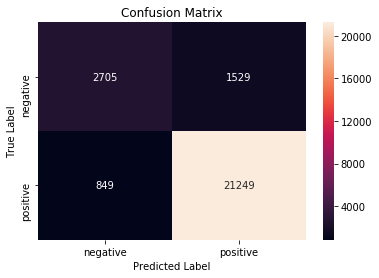

In [54]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)))
print("Test Confusion Matrix")
print(confusion_matrix(Y_test, lr.predict(X_test_vec_standardized)))
cm_test=confusion_matrix(Y_test, lr.predict(X_test_vec_standardized))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### More Sparsity(Few elements are non zero)  by incresing lambda(decreasing C)

In [55]:
#with lambda=1
clf = LogisticRegression(C=1, penalty='l1', n_jobs=-1)
clf.fit(X_train_vec_standardized, Y_train)
w = clf.coef_
print(np.count_nonzero(w))

3010


In [56]:
#with lambda=10
clf = LogisticRegression(C=0.1, penalty='l1', n_jobs=-1)
clf.fit(X_train_vec_standardized, Y_train)
w = clf.coef_
print(np.count_nonzero(w)) 

2699


In [57]:
#with lambda=100
clf = LogisticRegression(C=0.01, penalty='l1', n_jobs=-1)
clf.fit(X_train_vec_standardized, Y_train)
w = clf.coef_
print(np.count_nonzero(w))

1031


In [58]:
#with lambda=1000
clf = LogisticRegression(C=0.001, penalty='l1', n_jobs=-1)
clf.fit(X_train_vec_standardized, Y_train)
w = clf.coef_
print(np.count_nonzero(w))

66


#### MutltiCollinearity (Pertubation Test)

In [59]:
# Please write all the code with proper documentation
import scipy as sp
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# vector before adding epsilon
W_before_epsilon = lr.coef_
# Number of Non Zero elements in X_train_vec_standardized sparse matrix
no_of_non_zero = X_train_vec_standardized.count_nonzero()

# Creating a sparse matrix with epsilon at same position of non_Zero elements
indices_X_train = X_train_vec_standardized.indices
indptr_X_train = X_train_vec_standardized.indptr

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = X_train_vec_standardized.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,indices_X_train, indptr_X_train), shape=Shape, dtype=float)

#Non zero elemnt of X_train_vec_standardized
epsilon_lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train, Y_train) 

#Vector afer adding epsilon
W_after_epsilon = epsilon_lr.coef_

#change in vector after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon
#Sorting change vector
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]
sorted_change_vector[0,0:20]

array([ 0.00429631,  0.00392582,  0.00047938,  0.00019744,  0.0001754 ,
        0.00016882,  0.00016799,  0.00015374,  0.00014694,  0.00013831,
        0.0001379 ,  0.00013475,  0.00013139,  0.00013048,  0.00012975,
        0.00012149,  0.00012132,  0.00012111,  0.00011848,  0.00011456])

In [45]:
#Calculating percentiles from 0 to 100
import numpy as np
for i in range(11):
    print(str(i*10)+'th percentile ='+str(np.percentile(change_vector, i*10)))

0th percentile =-0.134208782239
10th percentile =-0.0445551146272
20th percentile =-0.0312453247959
30th percentile =-0.0206166743511
40th percentile =-0.0115368187643
50th percentile =-0.00278100693226
60th percentile =0.00628714887105
70th percentile =0.0149145101961
80th percentile =0.023935573124
90th percentile =0.0336618013167
100th percentile =0.112700997083


In [46]:
#calculating percentile from 90-100
for i in range(90,101):
     print(str(i)+'th percentile ='+str(np.percentile(change_vector, i)))

90th percentile =0.0336618013167
91th percentile =0.0351115583252
92th percentile =0.0366983395161
93th percentile =0.0382681684566
94th percentile =0.039614373147
95th percentile =0.0411112830356
96th percentile =0.0437766415077
97th percentile =0.0463839662837
98th percentile =0.0516674161117
99th percentile =0.0598006600492
100th percentile =0.112700997083


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [60]:
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:20]

all_features = count_vect.get_feature_names()
weight_values = lr.coef_

# Top 20 features are    
print("Top 20 features with their weight values :")

for j in top_index:
    print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

Top 20 features with their weight values :
       great	--> 	0.784759
      delici	--> 	0.614574
        best	--> 	0.585413
        love	--> 	0.546146
     perfect	--> 	0.494566
        good	--> 	0.479625
       excel	--> 	0.421833
  disappoint	--> 	-0.378094
        amaz	--> 	0.375767
      flaxse	--> 	0.358607
        nice	--> 	0.358496
      awesom	--> 	0.303590
        easi	--> 	0.303014
     favorit	--> 	0.289831
       worst	--> 	-0.283404
      wonder	--> 	0.276835
     satisfi	--> 	0.253566
        hook	--> 	0.252618
       tasti	--> 	0.246201
       thank	--> 	0.243505


#### Observation:
* By using RandomSearchCV L1 reg, got 0.91% AUC, considering absloute weights we can take top features.

## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

#### L2 Reguralization

In [61]:
tf_idf_vect = TfidfVectorizer(min_df=50)
X_train_vec = tf_idf_vect.fit_transform(X_train)
X_test_vec = tf_idf_vect.transform(X_test)
print("the type of count vectorizer ",type(X_train_vec))
print("the shape of out text TFIDF vectorizer ",X_train_vec.get_shape())
print("the number of unique words ", X_train_vec.get_shape()[1])

#Standardizing
sc = StandardScaler(with_mean=False)
X_train_vec_standardized = sc.fit_transform(X_train_vec)
X_test_vec_standardized = sc.transform(X_test_vec)

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (61441, 3062)
the number of unique words  3062


#### GridSearchCV Implementation Using L2 reg

In [62]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#using GridSearchCv
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring='accuracy', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n", model.best_estimator_)
print("Accuracy of model : ", model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The Optimal value Of C(1/lambda) is : ", optimal_C)

#Testing Logistic Regression with Optimal value of C:(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized, Y_train)
predictions = lr.predict(X_test_vec_standardized)

#varibles will be used at conclusion part
tfidf_l2_grid_C = optimal_C
tfidf_l2_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_l2_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of model :  0.913109524533
The Optimal value Of C(1/lambda) is :  0.01


In [63]:
#Evaluate Accuracy
acc = accuracy_score(Y_test, predictions)* 100
print('\nTest Accuracy Of Classifier C = %.3f is %f%%' % (optimal_C, acc))

#Evaluate Precision
acc = precision_score(Y_test, predictions)
print('\nTest Precsion Of Classifier C = %.3f is %f' % (optimal_C, acc))

#Evaluate Recall
acc = recall_score(Y_test, predictions)
print('\nTest recall  Of Classifier C = %.3f is %f' % (optimal_C, acc))

#Evaluate F1-score
acc = f1_score(Y_test, predictions)
print('\nTest F1-score  Of Classifier C = %.3f is %f' % (optimal_C, acc))


Test Accuracy Of Classifier C = 0.010 is 91.310952%

Test Precsion Of Classifier C = 0.010 is 0.936036

Test recall  Of Classifier C = 0.010 is 0.962214

Test F1-score  Of Classifier C = 0.010 is 0.948945


Train Confusion Matrix
[[ 7272  2675]
 [ 1324 50170]]
Test Confusion Matrix
[[ 2781  1453]
 [  835 21263]]


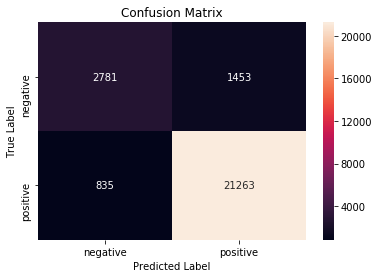

In [64]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)))
print("Test Confusion Matrix")
print(confusion_matrix(Y_test, lr.predict(X_test_vec_standardized)))
cm_test=confusion_matrix(Y_test, lr.predict(X_test_vec_standardized))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Random SearchCV Implementation

In [66]:
from scipy.stats import uniform
C = uniform(loc=0, scale=10)
hyperparameters = dict(C=C)
#Using Randomized Search
model = RandomizedSearchCV(LogisticRegression(penalty='l2'), hyperparameters, scoring='accuracy', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n", model.best_estimator_)
print("Accuracy of model : ", model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The Optimal value Of C(1/lambda) is : ", optimal_C)

#Testing Logistic Regression with Optimal value of C:(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized, Y_train)
predictions = lr.predict(X_test_vec_standardized)

#varibles will be used at conclusion part
tfidf_l2__random_C = optimal_C
tfidf_l2__random_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_l2__random_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=3.3582706284116903, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy of model :  0.912046179553
The Optimal value Of C(1/lambda) is :  3.35827062841


In [67]:
#Evaluate Accuracy
acc = accuracy_score(Y_test, predictions)* 100
print('\nTest Accuracy Of Classifier C = %f is %f%%' % (optimal_C, acc))

#Evaluate Precision
acc = precision_score(Y_test, predictions)
print('\nTest Precision Of Classifier C = %f is %f%%' % (optimal_C, acc))

#Evaluate Recall
acc = recall_score(Y_test, predictions)
print('\nTest recall  Of Classifier C = %f is %f%%' % (optimal_C, acc))

#Evaluate F1-score
acc = f1_score(Y_test, predictions)
print('\nTest F1-score  Of Classifier C = %f is %f%%' % (optimal_C, acc))


Test Accuracy Of Classifier C = 3.358271 is 91.204618%

Test Precision Of Classifier C = 3.358271 is 0.937345%

Test recall  Of Classifier C = 3.358271 is 0.959318%

Test F1-score  Of Classifier C = 3.358271 is 0.948204%


Train Confusion Matrix
[[ 7345  2602]
 [ 1385 50109]]
Test Confusion Matrix
[[ 2817  1417]
 [  899 21199]]


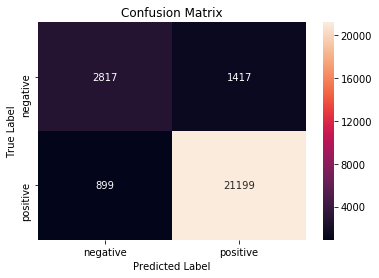

In [68]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)))
print("Test Confusion Matrix")
print(confusion_matrix(Y_test, lr.predict(X_test_vec_standardized)))
cm_test=confusion_matrix(Y_test, lr.predict(X_test_vec_standardized))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Grid SearchCV Using L1 reg

In [69]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#using GridSearchCv
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring='accuracy', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n", model.best_estimator_)
print("Accuracy of model : ", model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The Optimal value Of C(1/lambda) is : ", optimal_C)

#Testing Logistic Regression with Optimal value of C:(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized, Y_train)
predictions = lr.predict(X_test_vec_standardized)

#varibles will be used at conclusion part
tfidf_l1_grid_C = optimal_C
tfidf_l1_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_l1_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of model :  0.914476682364
The Optimal value Of C(1/lambda) is :  0.01


In [70]:
#Evaluate Accuracy
acc = accuracy_score(Y_test, predictions)* 100
print('\nTest Accuracy Of Classifier C = %f is %f%%' % (optimal_C, acc))

#Evaluate Precision
acc = precision_score(Y_test, predictions)
print('\nTest Precision Of Classifier C = %f is %f' % (optimal_C, acc))

#Evaluate Recall
acc = recall_score(Y_test, predictions)
print('\nTest recall  Of Classifier C = %f is %f' % (optimal_C, acc))

#Evaluate F1-score
acc = f1_score(Y_test, predictions)
print('\nTest F1-score  Of Classifier C = %f is %f' % (optimal_C, acc))


Test Accuracy Of Classifier C = 0.010000 is 91.451466%

Test Precision Of Classifier C = 0.010000 is 0.924753

Test recall  Of Classifier C = 0.010000 is 0.977690

Test F1-score  Of Classifier C = 0.010000 is 0.950485


Train Confusion Matrix
[[ 6195  3752]
 [  984 50510]]
Test Confusion Matrix
[[ 2476  1758]
 [  493 21605]]


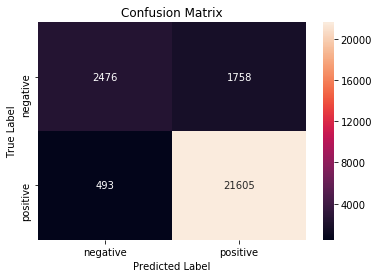

In [71]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)))
print("Test Confusion Matrix")
print(confusion_matrix(Y_test, lr.predict(X_test_vec_standardized)))
cm_test=confusion_matrix(Y_test, lr.predict(X_test_vec_standardized))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [72]:
from scipy.stats import uniform
C = uniform(loc=0, scale=10)
hyperparameters = dict(C=C)
#Using Randomized Search
model = RandomizedSearchCV(LogisticRegression(penalty='l1'), hyperparameters, scoring='accuracy', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n", model.best_estimator_)
print("Accuracy of model : ", model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The Optimal value Of C(1/lambda) is : ", optimal_C)

#Testing Logistic Regression with Optimal value of C:(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized, Y_train)
predictions = lr.predict(X_test_vec_standardized)

#varibles will be used at conclusion part
tfidf_l2__random_C = optimal_C
tfidf_l2__random_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_l2__random_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=0.64716998915554269, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy of model :  0.912387969011
The Optimal value Of C(1/lambda) is :  0.647169989156


In [73]:
#Evaluate Accuracy
acc = accuracy_score(Y_test, predictions)* 100
print('\nTest Accuracy Of Classifier C = %f is %f%%' % (optimal_C, acc))

#Evaluate Precision
acc = precision_score(Y_test, predictions)
print('\nTest Precision Of Classifier C = %f is %f' % (optimal_C, acc))

#Evaluate Recall
acc = recall_score(Y_test, predictions)
print('\nTest recall  Of Classifier C = %f is %f' % (optimal_C, acc))

#Evaluate F1-score
acc = f1_score(Y_test, predictions)
print('\nTest F1-score  Of Classifier C = %f is %f' % (optimal_C, acc))


Test Accuracy Of Classifier C = 0.647170 is 91.242595%

Test Precision Of Classifier C = 0.647170 is 0.937025

Test recall  Of Classifier C = 0.647170 is 0.960177

Test F1-score  Of Classifier C = 0.647170 is 0.948460


Train Confusion Matrix
[[ 7321  2626]
 [ 1368 50126]]
Test Confusion Matrix
[[ 2808  1426]
 [  880 21218]]


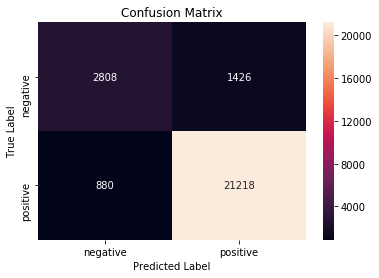

In [74]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)))
print("Test Confusion Matrix")
print(confusion_matrix(Y_test, lr.predict(X_test_vec_standardized)))
cm_test=confusion_matrix(Y_test, lr.predict(X_test_vec_standardized))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [75]:
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:20]

all_features = count_vect.get_feature_names()
weight_values = lr.coef_

# Top 20 features are    
print("Top 20 features with their weight values :")

for j in top_index:
    print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

Top 20 features with their weight values :
       great	--> 	0.865877
      delici	--> 	0.638451
        best	--> 	0.615747
        love	--> 	0.623230
     perfect	--> 	0.507448
        good	--> 	0.485410
       excel	--> 	0.468570
  disappoint	--> 	-0.328953
        amaz	--> 	0.384122
      flaxse	--> 	0.109782
        nice	--> 	0.357131
      awesom	--> 	0.336114
        easi	--> 	0.296673
     favorit	--> 	0.312992
       worst	--> 	-0.283929
      wonder	--> 	0.287270
     satisfi	--> 	0.257339
        hook	--> 	0.297887
       tasti	--> 	0.232109
       thank	--> 	0.259429


#### Observation:
* From the above we can observe that there is not much larger change in weight vector, we will use absolute weights.

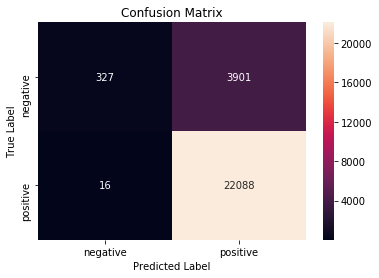

In [56]:
lr=LogisticRegression(penalty='l1', C=optimal_c)
lr.fit(X_train_tf, y_tr)
predic=lr.predict(X_test_tf)
conf_mat = confusion_matrix(y_test, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot= True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [45]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
all_features=count_vect.get_feature_names()
model=LogisticRegression(penalty='l2', C=c)
model.fit(X_train,y_train)
weight = lr.coef_
pos_ndx=np.argsort(weight)[:,::-1]
neg_ndx=np.argsort(weight)
print('\nTop 10 Positive Features :')
for i in list(pos_ndx[0][0:10]):
    print(all_features[i])


Top 10 Positive Features :
benefited
aficionada
arived
carbquik
bing
belgain
breastfeeding
admin
byproduct
breatfeeding


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [46]:
# Please write all the code with proper documentation
weight = lr.coef_
pos_ndx=np.argsort(weight)[:,::-1]
neg_ndx=np.argsort(weight)
print('\nTop 10 Negative Features :')
for i in list(neg_ndx[0][0:10]):
    print(all_features[i])


Top 10 Negative Features :
cadavers
bishon
creamyoesk
course
babaganouge
biscuits
convince
confirms
askes
chilean


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [76]:
#List of sentance in X_train text
sent_of_train = []
for sent in X_train:
    sent_of_train.append(sent.split())
    
#List of sentance in X_test text
sent_of_test = []
for sent in X_test:
    sent_of_test.append(sent.split())
#Train your own text corpus WOrd2Vec
w2v_model = Word2Vec(sent_of_train,min_count=5,size=50,workers=4)   
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9941
sample words  ['weekend', 'week', 'long', 'fast', 'use', 'rice', 'green', 'tea', 'work', 'wonder', 'one', 'energi', 'level', 'tasti', 'even', 'bit', 'salt', 'make', 'much', 'pleasant', 'famili', 'favorit', 'flavor', 'hansen', 'diet', 'soda', 'clean', 'crisp', 'tast', 'enjoy', 'meal', 'calm', 'upset', 'tummi', 'love', 'compar', 'eat', 'like', 'nissin', 'maruchan', 'realli', 'tell', 'differ', 'big', 'tub', 'spice', 'drop', 'better', 'diabet', 'didnt']


In [77]:
#copute AvgWord2Vec for each review of X_train
train_vectors = [];
for sent in sent_of_train:
    sent_vec = np.zeros(50)
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)

#compute AvgWord2Vec for each review of X_test
test_vectors = [];
for sent in sent_of_test:
    sent_vec = np.zeros(50)
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)

#Standardizing
sc = StandardScaler()
X_train_vec_standardized = sc.fit_transform(train_vectors)
X_test_vec_standardized = sc.transform(test_vectors)

#### L2 regualrization
#### Grid SearchCV

In [78]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#using GridSearchCv
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring='accuracy', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n", model.best_estimator_)
print("Accuracy of model : ", model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The Optimal value Of C(1/lambda) is : ", optimal_C)

#Testing Logistic Regression with Optimal value of C:(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized, Y_train)
predictions = lr.predict(X_test_vec_standardized)

#varibles will be used at conclusion part
avg_w2v_l2_grid_C = optimal_C
avg_w2v_l2_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
avg_w2v_l2_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of model :  0.887095549142
The Optimal value Of C(1/lambda) is :  1


In [79]:
#Evaluate Accuracy
acc = accuracy_score(Y_test, predictions)* 100
print('\nTest Accuracy Of Classifier C = %.3f is %f%%' % (optimal_C, acc))

#Evaluate Precision
acc = precision_score(Y_test, predictions)
print('\nTest Precsion Of Classifier C = %.3f is %f' % (optimal_C, acc))

#Evaluate Recall
acc = recall_score(Y_test, predictions)
print('\nTest recall  Of Classifier C = %.3f is %f' % (optimal_C, acc))

#Evaluate F1-score
acc = f1_score(Y_test, predictions)
print('\nTest F1-score  Of Classifier C = %.3f is %f' % (optimal_C, acc))


Test Accuracy Of Classifier C = 1.000 is 88.709555%

Test Precsion Of Classifier C = 1.000 is 0.905345

Test recall  Of Classifier C = 1.000 is 0.966513

Test F1-score  Of Classifier C = 1.000 is 0.934930


Train Confusion Matrix
[[ 4794  5153]
 [ 1782 49712]]
Test Confusion Matrix
[[ 2001  2233]
 [  740 21358]]


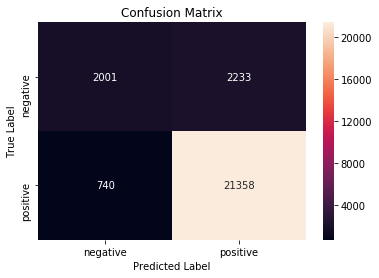

In [80]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)))
print("Test Confusion Matrix")
print(confusion_matrix(Y_test, lr.predict(X_test_vec_standardized)))
cm_test=confusion_matrix(Y_test, lr.predict(X_test_vec_standardized))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observation:
* Model is performing well on unseen data, with an AUC of 0.91% , considering time split is helpfull by training data 
  on unseen data points.
* Using GridSearchCV and Random SearchCV of L1, L2 reg.

#### RandomizedSearch CV implementation

In [81]:
from scipy.stats import uniform
C = uniform(loc=0, scale=10)
hyperparameters = dict(C=C)
#Using Randomized Search
model = RandomizedSearchCV(LogisticRegression(penalty='l2'), hyperparameters, scoring='accuracy', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n", model.best_estimator_)
print("Accuracy of model : ", model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The Optimal value Of C(1/lambda) is : ", optimal_C)

#Testing Logistic Regression with Optimal value of C:(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized, Y_train)
predictions = lr.predict(X_test_vec_standardized)

#varibles will be used at conclusion part
avg_w2v_l2__random_C = optimal_C
avg_w2v_l2__random_train_acc = model.score(X_test_vec_standardized, Y_test)*100
avg_w2v_l2__random_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=1.6718880897136257, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy of model :  0.887133525748
The Optimal value Of C(1/lambda) is :  1.67188808971


In [82]:
#Evaluate Accuracy
acc = accuracy_score(Y_test, predictions)* 100
print('\nTest Accuracy Of Classifier C = %.3f is %f%%' % (optimal_C, acc))

#Evaluate Precision
acc = precision_score(Y_test, predictions)
print('\nTest Precsion Of Classifier C = %.3f is %f' % (optimal_C, acc))

#Evaluate Recall
acc = recall_score(Y_test, predictions)
print('\nTest recall  Of Classifier C = %.3f is %f' % (optimal_C, acc))

#Evaluate F1-score
acc = f1_score(Y_test, predictions)
print('\nTest F1-score  Of Classifier C = %.3f is %f' % (optimal_C, acc))


Test Accuracy Of Classifier C = 1.672 is 88.713353%

Test Precsion Of Classifier C = 1.672 is 0.905384

Test recall  Of Classifier C = 1.672 is 0.966513

Test F1-score  Of Classifier C = 1.672 is 0.934950


Train Confusion Matrix
[[ 4794  5153]
 [ 1781 49713]]
Test Confusion Matrix
[[ 2002  2232]
 [  740 21358]]


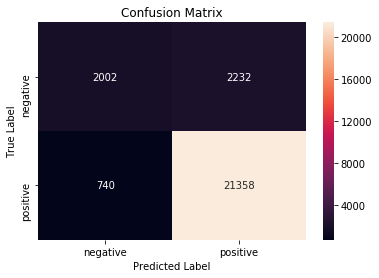

In [83]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)))
print("Test Confusion Matrix")
print(confusion_matrix(Y_test, lr.predict(X_test_vec_standardized)))
cm_test=confusion_matrix(Y_test, lr.predict(X_test_vec_standardized))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### L1 reg(GridSearch CV)

In [84]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#using GridSearchCv
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring='accuracy', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n", model.best_estimator_)
print("Accuracy of model : ", model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The Optimal value Of C(1/lambda) is : ", optimal_C)

#Testing Logistic Regression with Optimal value of C:(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized, Y_train)
predictions = lr.predict(X_test_vec_standardized)

#varibles will be used at conclusion part
avg_w2v_l2_grid_C = optimal_C
avg_w2v_l2_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
avg_w2v_l2_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of model :  0.887057572535
The Optimal value Of C(1/lambda) is :  10000


In [85]:
#Evaluate Accuracy
acc = accuracy_score(Y_test, predictions)* 100
print('\nTest Accuracy Of Classifier C = %.3f is %f%%' % (optimal_C, acc))

#Evaluate Precision
acc = precision_score(Y_test, predictions)
print('\nTest Precsion Of Classifier C = %.3f is %f' % (optimal_C, acc))

#Evaluate Recall
acc = recall_score(Y_test, predictions)
print('\nTest recall  Of Classifier C = %.3f is %f' % (optimal_C, acc))

#Evaluate F1-score
acc = f1_score(Y_test, predictions)
print('\nTest F1-score  Of Classifier C = %.3f is %f' % (optimal_C, acc))


Test Accuracy Of Classifier C = 10000.000 is 88.705757%

Test Precsion Of Classifier C = 10000.000 is 0.905341

Test recall  Of Classifier C = 10000.000 is 0.966468

Test F1-score  Of Classifier C = 10000.000 is 0.934906


Train Confusion Matrix
[[ 4795  5152]
 [ 1781 49713]]
Test Confusion Matrix
[[ 2001  2233]
 [  741 21357]]


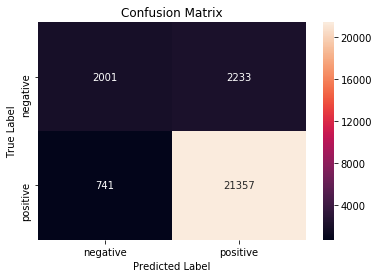

In [86]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)))
print("Test Confusion Matrix")
print(confusion_matrix(Y_test, lr.predict(X_test_vec_standardized)))
cm_test=confusion_matrix(Y_test, lr.predict(X_test_vec_standardized))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Randomized Search CV implementation

In [87]:
from scipy.stats import uniform
C = uniform(loc=0, scale=10)
hyperparameters = dict(C=C)
#Using Randomized Search
model = RandomizedSearchCV(LogisticRegression(penalty='l1'), hyperparameters, scoring='accuracy', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n", model.best_estimator_)
print("Accuracy of model : ", model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The Optimal value Of C(1/lambda) is : ", optimal_C)

#Testing Logistic Regression with Optimal value of C:(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized, Y_train)
predictions = lr.predict(X_test_vec_standardized)

#varibles will be used at conclusion part
avg_w2v_l1__random_C = optimal_C
avg_w2v_l1__random_train_acc = model.score(X_test_vec_standardized, Y_test)*100
avg_w2v_l1_random_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=3.9567484580891312, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy of model :  0.887171502355
The Optimal value Of C(1/lambda) is :  3.95674845809


In [88]:
#Evaluate Accuracy
acc = accuracy_score(Y_test, predictions)* 100
print('\nTest Accuracy Of Classifier C = %.3f is %f%%' % (optimal_C, acc))

#Evaluate Precision
acc = precision_score(Y_test, predictions)
print('\nTest Precsion Of Classifier C = %.3f is %f' % (optimal_C, acc))

#Evaluate Recall
acc = recall_score(Y_test, predictions)
print('\nTest recall  Of Classifier C = %.3f is %f' % (optimal_C, acc))

#Evaluate F1-score
acc = f1_score(Y_test, predictions)
print('\nTest F1-score  Of Classifier C = %.3f is %f' % (optimal_C, acc))


Test Accuracy Of Classifier C = 3.957 is 88.717150%

Test Precsion Of Classifier C = 3.957 is 0.905388

Test recall  Of Classifier C = 3.957 is 0.966558

Test F1-score  Of Classifier C = 3.957 is 0.934973


Train Confusion Matrix
[[ 4794  5153]
 [ 1782 49712]]
Test Confusion Matrix
[[ 2002  2232]
 [  739 21359]]


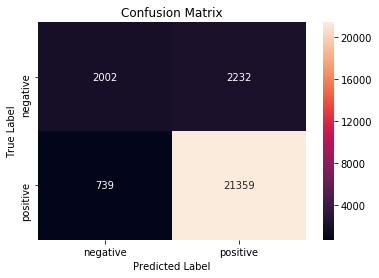

In [89]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)))
print("Test Confusion Matrix")
print(confusion_matrix(Y_test, lr.predict(X_test_vec_standardized)))
cm_test=confusion_matrix(Y_test, lr.predict(X_test_vec_standardized))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observation:
* Model is performing well on unseen data, with an AUC of 0.88% , considering time split is helpfull by training data 
  on unseen data points.
* Using GridSearchCV and Random SearchCV of L1, L2 reg
* Compare to other models TFIDF is also performing well with the above datapoints.

In [44]:
# Please write all the code with proper documentation
#Word2Vec for train
i=0
list_of_sentance_tr=[]
for sentance in X_tr:
    list_of_sentance_tr.append(sentance.split())
w2v_model = Word2Vec(list_of_sentance_tr,min_count=5,size=50,workers=4)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_tr): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_tr.append(sent_vec)
print(len(sent_vectors_tr))
print(len(sent_vectors_tr[0]))

#For cross validation we can use same word2vec model
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
w2v_model = Word2Vec(list_of_sentance_cv,min_count=5,size=50,workers=4)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_tr.append(sent_vec)
print(len(sent_vectors_cv))

#for test data
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
w2v_model = Word2Vec(list_of_sentance_test,min_count=5,size=50,workers=4)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 43008/43008 [01:53<00:00, 412.11it/s]


43008
50


100%|███████████████████████████████████████████████████████████████████████████| 18433/18433 [00:44<00:00, 416.94it/s]


0


100%|███████████████████████████████████████████████████████████████████████████| 26332/26332 [00:57<00:00, 461.00it/s]


26332
50


### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [ ]:
# Please write all the code with proper documentation
X_train_w2v=sent_vectors_tr
X_cv_w2v=sent_vectors_cv
X_test_w2v=sent_vectors_test

C = [10**-3, 10**-2, 10**0, 10**2,10**3,10**4]#C=1/lambda
auc_train=[]
auc_cv=[]
for c in C:
    lr=LogisticRegression(penalty='l1',C=c)
    lr.fit(X_train_w2v,y_tr)
    probcv=lr.predict_proba(X_cv_w2v)[:,1]
    auc_cv.append(roc_auc_score(y_cv,probcv))
    probtr=lr.predict_proba(X_train_w2v)[:,1]
    auc_train.append(roc_auc_score(y_tr,probtr))
optimal_c= C[auc_cv.index(max(auc_cv))]
C=[math.log(x) for x in C]#converting values of C into logarithm
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(C, auc_train, label='AUC train')
ax.plot(C, auc_cv, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('C (1/lambda)')
plt.ylabel('AUC')
ax.legend()
plt.show()
print('optimal lambda for which auc is maximum : ',1//optimal_c)

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [151]:
# Please write all the code with proper documentation
# collect different 100k rows without repetition from time_sorted_data DataFrfame
my_final = time_sorted_data.take(np.random.permutation(len(final))[:100000])
print(my_final.shape)

x = my_final['cleanedText'].values
y = my_final['Score']
#SPlit the dataset into Train and Test
X_train,X_test,Y_train,Y_test=train_test_split(x, y, test_size=0.3, random_state=0)

#List of sentance in X_train text
sent_of_train = []
for sent in X_train:
    sent_of_train.append(sent.split())
    
#List of sentance in X_test text
sent_of_test = []
for sent in X_test:
    sent_of_test.append(sent.split())
#Train your own text corpus WOrd2Vec
w2v_model = Word2Vec(sent_of_train,min_count=5,size=50,workers=4)   
w2v_words = list(w2v_model.wv.vocab)

(87773, 11)


In [152]:
#TF-IDF weighted word2vec
tf_idf_vect = TfidfVectorizer()
final_tf_idf1 = tf_idf_vect.fit_transform(X_train)
tfidf_feat=tf_idf_vect.get_feature_names()

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [166]:
#compute TFIDF weighted word2vec of each review of X_train
#copute AvgWord2Vec for each review of X_train
tfidf_train_vectors = [];
row=0;
for sent in sent_of_train:
    sent_vec = np.zeros(50)
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1  

In [167]:
tfidf_test_vectors = [];
row=0;
for sent in sent_of_test:
    sent_vec = np.zeros(50)
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1  
#Standardizing
sc = StandardScaler()
X_train_vec_standardized = sc.fit_transform(tfidf_train_vectors)
X_test_vec_standardized = sc.transform(tfidf_test_vectors)

#### GridSearch CV implementation

In [168]:
# Please write all the code with proper documentation
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#using GridSearchCv
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring='accuracy', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n", model.best_estimator_)
print("Accuracy of model : ", model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The Optimal value Of C(1/lambda) is : ", optimal_C)

#Testing Logistic Regression with Optimal value of C:(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized, Y_train)
predictions = lr.predict(X_test_vec_standardized)

#varibles will be used at conclusion part
tfidf_w2v_l2_grid_C = optimal_C
tfidf_w2v_l2_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_w2v_l2_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of model :  0.561142336321
The Optimal value Of C(1/lambda) is :  10000


In [169]:
#Evaluate Accuracy
acc = accuracy_score(Y_test, predictions)* 100
print('\nTest Accuracy Of Classifier C = %.3f is %f%%' % (optimal_C, acc))

#Evaluate Precision
acc = precision_score(Y_test, predictions)
print('\nTest Precsion Of Classifier C = %.3f is %f' % (optimal_C, acc))

#Evaluate Recall
acc = recall_score(Y_test, predictions)
print('\nTest recall  Of Classifier C = %.3f is %f' % (optimal_C, acc))

#Evaluate F1-score
acc = f1_score(Y_test, predictions)
print('\nTest F1-score  Of Classifier C = %.3f is %f' % (optimal_C, acc))


Test Accuracy Of Classifier C = 10000.000 is 56.114234%

Test Precsion Of Classifier C = 10000.000 is 0.870239

Test recall  Of Classifier C = 10000.000 is 0.562652

Test F1-score  Of Classifier C = 10000.000 is 0.683432


Train Confusion Matrix
[[ 4005  6014]
 [ 1722 49700]]
Test Confusion Matrix
[[ 2302  1860]
 [ 9696 12474]]


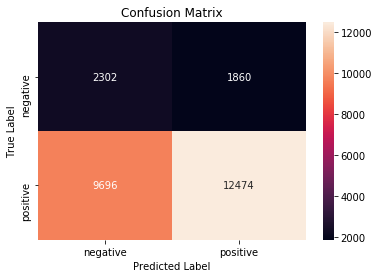

In [170]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)))
print("Test Confusion Matrix")
print(confusion_matrix(Y_test, lr.predict(X_test_vec_standardized)))
cm_test=confusion_matrix(Y_test, lr.predict(X_test_vec_standardized))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### RandomizedSearch CV

In [171]:
from scipy.stats import uniform
C = uniform(loc=0, scale=10)
hyperparameters = dict(C=C)
#Using Randomized Search
model = RandomizedSearchCV(LogisticRegression(penalty='l2'), hyperparameters, scoring='accuracy', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n", model.best_estimator_)
print("Accuracy of model : ", model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The Optimal value Of C(1/lambda) is : ", optimal_C)

#Testing Logistic Regression with Optimal value of C:(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized, Y_train)
predictions = lr.predict(X_test_vec_standardized)

#varibles will be used at conclusion part
tfidf_w2v_l2__random_C = optimal_C
tfidf_w2v_l2__random_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_w2v_l2_random_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=7.3240061567146064, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy of model :  0.561142336321
The Optimal value Of C(1/lambda) is :  7.32400615671


In [172]:
#Evaluate Accuracy
acc = accuracy_score(Y_test, predictions)* 100
print('\nTest Accuracy Of Classifier C = %.3f is %f%%' % (optimal_C, acc))

#Evaluate Precision
acc = precision_score(Y_test, predictions)
print('\nTest Precsion Of Classifier C = %.3f is %f' % (optimal_C, acc))

#Evaluate Recall
acc = recall_score(Y_test, predictions)
print('\nTest recall  Of Classifier C = %.3f is %f' % (optimal_C, acc))

#Evaluate F1-score
acc = f1_score(Y_test, predictions)
print('\nTest F1-score  Of Classifier C = %.3f is %f' % (optimal_C, acc))


Test Accuracy Of Classifier C = 7.324 is 56.114234%

Test Precsion Of Classifier C = 7.324 is 0.870239

Test recall  Of Classifier C = 7.324 is 0.562652

Test F1-score  Of Classifier C = 7.324 is 0.683432


Train Confusion Matrix
[[ 4005  6014]
 [ 1722 49700]]
Test Confusion Matrix
[[ 2302  1860]
 [ 9696 12474]]


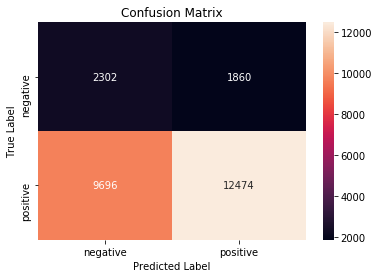

In [173]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)))
print("Test Confusion Matrix")
print(confusion_matrix(Y_test, lr.predict(X_test_vec_standardized)))
cm_test=confusion_matrix(Y_test, lr.predict(X_test_vec_standardized))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### L1 Reguralization(GridSearchCV)

In [174]:
# Please write all the code with proper documentation
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#using GridSearchCv
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring='accuracy', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n", model.best_estimator_)
print("Accuracy of model : ", model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The Optimal value Of C(1/lambda) is : ", optimal_C)

#Testing Logistic Regression with Optimal value of C:(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized, Y_train)
predictions = lr.predict(X_test_vec_standardized)

#varibles will be used at conclusion part
tfidf_w2v_l1_grid_C = optimal_C
tfidf_w2v_l1_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_w2v_l1_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of model :  0.561142336321
The Optimal value Of C(1/lambda) is :  100


In [175]:
#Evaluate Accuracy
acc = accuracy_score(Y_test, predictions)* 100
print('\nTest Accuracy Of Classifier C = %.3f is %f%%' % (optimal_C, acc))

#Evaluate Precision
acc = precision_score(Y_test, predictions)
print('\nTest Precsion Of Classifier C = %.3f is %f' % (optimal_C, acc))

#Evaluate Recall
acc = recall_score(Y_test, predictions)
print('\nTest recall  Of Classifier C = %.3f is %f' % (optimal_C, acc))

#Evaluate F1-score
acc = f1_score(Y_test, predictions)
print('\nTest F1-score  Of Classifier C = %.3f is %f' % (optimal_C, acc))


Test Accuracy Of Classifier C = 100.000 is 56.114234%

Test Precsion Of Classifier C = 100.000 is 0.870239

Test recall  Of Classifier C = 100.000 is 0.562652

Test F1-score  Of Classifier C = 100.000 is 0.683432


Train Confusion Matrix
[[ 4005  6014]
 [ 1722 49700]]
Test Confusion Matrix
[[ 2302  1860]
 [ 9696 12474]]


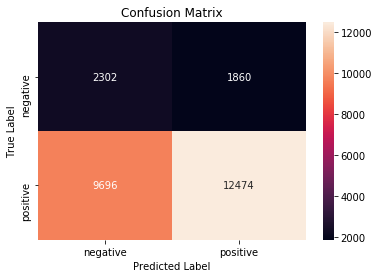

In [176]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)))
print("Test Confusion Matrix")
print(confusion_matrix(Y_test, lr.predict(X_test_vec_standardized)))
cm_test=confusion_matrix(Y_test, lr.predict(X_test_vec_standardized))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### RandomizedSearch CV

In [177]:
from scipy.stats import uniform
C = uniform(loc=0, scale=10)
hyperparameters = dict(C=C)
#Using Randomized Search
model = RandomizedSearchCV(LogisticRegression(penalty='l1'), hyperparameters, scoring='accuracy', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n", model.best_estimator_)
print("Accuracy of model : ", model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The Optimal value Of C(1/lambda) is : ", optimal_C)

#Testing Logistic Regression with Optimal value of C:(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized, Y_train)
predictions = lr.predict(X_test_vec_standardized)

#varibles will be used at conclusion part
tfidf_w2v_l1__random_C = optimal_C
tfidf_w2v_l1__random_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_w2v_l1_random_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=6.5337095660713036, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy of model :  0.561180312927
The Optimal value Of C(1/lambda) is :  6.53370956607


In [178]:
#Evaluate Accuracy
acc = accuracy_score(Y_test, predictions)* 100
print('\nTest Accuracy Of Classifier C = %.3f is %f%%' % (optimal_C, acc))

#Evaluate Precision
acc = precision_score(Y_test, predictions)
print('\nTest Precsion Of Classifier C = %.3f is %f' % (optimal_C, acc))

#Evaluate Recall
acc = recall_score(Y_test, predictions)
print('\nTest recall  Of Classifier C = %.3f is %f' % (optimal_C, acc))

#Evaluate F1-score
acc = f1_score(Y_test, predictions)
print('\nTest F1-score  Of Classifier C = %.3f is %f' % (optimal_C, acc))


Test Accuracy Of Classifier C = 6.534 is 56.118031%

Test Precsion Of Classifier C = 6.534 is 0.870248

Test recall  Of Classifier C = 6.534 is 0.562697

Test F1-score  Of Classifier C = 6.534 is 0.683468


Train Confusion Matrix
[[ 4004  6015]
 [ 1722 49700]]
Test Confusion Matrix
[[ 2302  1860]
 [ 9695 12475]]


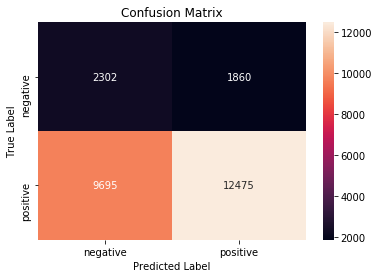

In [179]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)))
print("Test Confusion Matrix")
print(confusion_matrix(Y_test, lr.predict(X_test_vec_standardized)))
cm_test=confusion_matrix(Y_test, lr.predict(X_test_vec_standardized))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# [6] Conclusions

In [188]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Feature Engineering", "Hyperparameter(Alpha)", "AUC"]
x.add_row(["BOW", "GridSearchCV L2", 0.01, 0.910])
x.add_row(["TFDIF", "RandomSearchCV L2", 0.01, 0.931])
x.add_row(["AVG Word2Vec", "GridSearchCV L1", 0.1, 0.931])
x.add_row(["TFDIF Word2Vec", "RandomSearchCV L1", 100, 0.56])

x.add_row(["BOW", "GridSearchCV L1", 1, 0.917])
x.add_row(["TFIDF", 'RandomSearchCV L1', 0.1, 0.959])
x.add_row(["AVG Word2Vec", "GridSearchCV L2", 10000, 0.931])
x.add_row(["TFDIF Word2Vec", "RandomSearchCV L2", 100, 0.561])

print(x)

+----------------+---------------------+-----------------------+-------+
|   Vectorizer   | Feature Engineering | Hyperparameter(Alpha) |  AUC  |
+----------------+---------------------+-----------------------+-------+
|      BOW       |   GridSearchCV L2   |          0.01         |  0.91 |
|     TFDIF      |  RandomSearchCV L2  |          0.01         | 0.931 |
|  AVG Word2Vec  |   GridSearchCV L1   |          0.1          | 0.931 |
| TFDIF Word2Vec |  RandomSearchCV L1  |          100          |  0.56 |
|      BOW       |   GridSearchCV L1   |           1           | 0.917 |
|     TFIDF      |  RandomSearchCV L1  |          0.1          | 0.959 |
|  AVG Word2Vec  |   GridSearchCV L2   |         10000         | 0.931 |
| TFDIF Word2Vec |  RandomSearchCV L2  |          100          | 0.561 |
+----------------+---------------------+-----------------------+-------+


* Model is performing well on unseen data, with an AUC of 0.91% , considering time split is helpfull by training data 
  on unseen data points for BOW Model.
* Using GridSearchCV and Random SearchCV of L1, L2 reg, comparing AUC there is bit imprrovement over models.
* Using TFIDF Word2Vec observed that model is not performing so well compartively with other models.
* We have to balance the train and test bias, such that not to overfit and underfit(Bias Variance TradeOff).
* Using Time Series Split taking chunk of train data which is helpful factor.
* LogisticRegression Is good for Text Classification task Prediction.